<a href="https://colab.research.google.com/github/MereumF/EMBSEEGCOMP/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Identify whether a CUDA-enabled GPU is available
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    msg ='CUDA-enabled GPU found. Training should be faster.'
else:
    msg = (
        "No GPU found. Training will be carried out on CPU, which might be "
        "slower.\n\nIf running on Google Colab, you can request a GPU runtime by"
        " clicking\n`Runtime/Change runtime type` in the top bar menu, then "
        "selecting \'T4 GPU\'\nunder \'Hardware accelerator\'."
    )
print(msg)

CUDA-enabled GPU found. Training should be faster.


In [3]:
#@title ▶️ Install additional required packages for colab
!pip install braindecode
!pip install eegdash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 143.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 162.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.

In [4]:
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

from eegdash.dataset import EEGChallengeDataset

dataset_ccd = EEGChallengeDataset(task="contrastChangeDetection",
                                  release="R1", cache_dir=DATA_DIR,
                                  mini=True)


╭─────────────────────────────────────── EEG 2025 Competition Data Notice ────────────────────────────────────────╮
│ This object loads the HBN dataset that has been preprocessed for the EEG Challenge:                             │
│   * Downsampled from 500Hz to 100Hz                                                                             │
│   * Bandpass filtered (0.5-50 Hz)                                                                               │
│                                                                                                                 │
│ For full preprocessing applied for competition details, see:                                                    │
│   ]8;id=815752;https://github.com/eeg2025/downsample-datasets\https://github.com/eeg2025/downsample-datasets]8;;\                                                                │
│                                                                                                                 │
│ The HBN dataset have some preprocessing applied by the HBN team:                                                │
│   * Re-reference (Cz Channel)                                                                                   │
│                                                                                                                 │
│ IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from ]8;id=529314;https://github.com/sccn/EEGDash/blob/develop/eegdash/api.py\EEGDashDataset]8;;\     │
│ directly.                                                                                                       │
│ If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the    │
│ challenge data.                                                                                                 │
╰────────────────────────────────────────── Source: EEGChallengeDataset ──────────────────────────────────────────╯

In [5]:
#@title ▶️ Run this first to get all the utils functions for the epoching
from braindecode.datasets import BaseConcatDataset


In [6]:
from braindecode.preprocessing import preprocess, Preprocessor, create_windows_from_events
from eegdash.hbn.windows import (
    annotate_trials_with_target,
    add_aux_anchors,
    add_extras_columns,
    keep_only_recordings_with,
)

EPOCH_LEN_S = 2.0
SFREQ = 100 # by definition here

transformation_offline = [
    Preprocessor(
        annotate_trials_with_target,
        target_field="rt_from_stimulus", epoch_length=EPOCH_LEN_S,
        require_stimulus=True, require_response=True,
        apply_on_array=False,
    ),
    Preprocessor(add_aux_anchors, apply_on_array=False),
]
preprocess(dataset_ccd, transformation_offline, n_jobs=1)

ANCHOR = "stimulus_anchor"

SHIFT_AFTER_STIM = 0.5
WINDOW_LEN       = 2.0

# Keep only recordings that actually contain stimulus anchors
dataset = keep_only_recordings_with(ANCHOR, dataset_ccd)

# Create single-interval windows (stim-locked, long enough to include the response)
single_windows = create_windows_from_events(
    dataset,
    mapping={ANCHOR: 0},
    trial_start_offset_samples=int(SHIFT_AFTER_STIM * SFREQ),                 # +0.5 s
    trial_stop_offset_samples=int((SHIFT_AFTER_STIM + WINDOW_LEN) * SFREQ),   # +2.5 s
    window_size_samples=int(EPOCH_LEN_S * SFREQ),
    window_stride_samples=SFREQ,
    preload=True,
)

# Injecting metadata into the extra mne annotation.
single_windows = add_extras_columns(
    single_windows,
    dataset,
    desc=ANCHOR,
    keys=("target", "rt_from_stimulus", "rt_from_trialstart",
          "stimulus_onset", "response_onset", "correct", "response_type")
          )

Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_(

Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_(

In [7]:
# for each windows, we can extract the metainformation using:

meta_information = single_windows.get_metadata()

In [8]:
meta_information.head()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,rt_from_stimulus,rt_from_trialstart,stimulus_onset,response_onset,correct,response_type,...,thepresent,diaryofawimpykid,contrastchangedetection_1,contrastchangedetection_2,contrastchangedetection_3,surroundsupp_1,surroundsupp_2,seqlearning6target,seqlearning8target,symbolsearch
0,0,4278,4478,2.13,2.13,4.93,42.284,44.414,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
1,0,4798,4998,1.96,1.96,4.76,47.484,49.444,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
2,0,5478,5678,2.02,2.02,6.42,54.284,56.304,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
3,0,6318,6518,1.72,1.72,7.72,62.684,64.404,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
4,0,6838,7038,1.8,1.8,4.6,67.884,69.684,1,left_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available


In [9]:
import numpy as np
male = 0
female = 0

subject_ids = meta_information["subject"].unique()
print("Subject ID's: ", subject_ids)
print("Ages: ", meta_information["age"].unique())

participants_summary = meta_information[['subject', 'sex']].drop_duplicates()

for i in participants_summary['sex']:
  if i == 'M':
    male +=1
  elif i == 'F':
    female +=1
print("Num of Males: ", male, ". Num of Females: ", female)


Subject ID's:  ['NDARAC904DMU' 'NDARAM704GKZ' 'NDARAP359UM6' 'NDARBD879MBX'
 'NDARBH024NH2' 'NDARBK082PDD' 'NDARCA153NKE' 'NDARCE721YB5'
 'NDARCJ594BWQ' 'NDARCN669XPR' 'NDARCW094JCG' 'NDARCZ947WU5'
 'NDARDH670PXH' 'NDARDL511UND' 'NDARDU986RBM' 'NDAREM731BYM'
 'NDAREN519BLJ' 'NDARFK610GY5' 'NDARFT581ZW5' 'NDARFW972KFQ']
Ages:  [11.3386 10.9449 12.8422 13.9757  8.6883  8.3652  6.7472  6.6821 12.4585
  9.6883  8.453   9.3646 13.0092 10.2002  9.926  11.8507  7.0291 10.5204
  6.7034 12.4397]
Num of Males:  12 . Num of Females:  8


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state


subjects = meta_information["subject"].unique()
sub_rm = ['NDARAC904DMU' 'NDARAM704GKZ' 'NDARAP359UM6' 'NDARBD879MBX'
 'NDARBH024NH2' 'NDARBK082PDD' 'NDARCA153NKE' 'NDARCE721YB5']
subjects = [s for s in subjects if s not in sub_rm]

train_subj, test_subj = train_test_split(
    subjects, test_size= 0.2 ,random_state=check_random_state(42),shuffle=True)

# sanity check
assert (set(test_subj) | set(train_subj)) == set(subjects)

In [11]:
# and finally using braindecode split function, we can do:
subject_split = single_windows.split("subject")

train_set = []
test_set = []

for s in subject_split:
    if s in train_subj:
        train_set.append(subject_split[s])

    elif s in test_subj:
        test_set.append(subject_split[s])

train_set = BaseConcatDataset(train_set)
test_set = BaseConcatDataset(test_set)

print("Number of examples in each split in the minirelease")
print(f"Train:\t{len(train_set)}")
print(f"Test:\t{len(test_set)}")

Number of examples in each split in the minirelease
Train:	1215
Test:	298


In [12]:
window_1 = train_set[15]
#5816 - 5616 = 200 ms --> 2 second window
print("Target of Window #1:", window_1[1])
window_1

Target of Window #1: [1.68]


(array([[ 8.4653084e-06,  6.9837538e-06,  8.5758184e-06, ...,
         -2.2782110e-06,  4.8885527e-06,  9.5120104e-06],
        [ 6.1124933e-06, -2.4088030e-07, -3.9789420e-06, ...,
         -5.5053088e-06,  1.2936817e-06, -1.1614809e-06],
        [ 1.0517597e-05,  5.1259985e-06,  3.1034187e-06, ...,
          3.7373013e-06,  1.0063539e-05,  9.2520795e-06],
        ...,
        [ 2.3057412e-06,  1.9893582e-06,  2.7084332e-06, ...,
         -1.5831420e-05, -3.9213096e-06,  7.7311079e-06],
        [ 5.5845740e-06,  5.4351758e-06,  7.9951215e-06, ...,
         -4.3637374e-06,  7.1913250e-06,  1.9386855e-05],
        [ 5.0000005e-13,  5.0000005e-13,  5.0000005e-13, ...,
          5.0000005e-13,  5.0000005e-13,  5.0000005e-13]], dtype=float32),
 array([1.68]),
 [0, 16336, 16536])

In [13]:
EEG_1, target_1 = train_set[19][:2]  # first element = EEG, second = target
print(EEG_1, target_1)

[[ 2.0016765e-05  2.3812070e-05  2.2369599e-05 ...  2.1007763e-05
   3.2342696e-06  5.9680483e-06]
 [ 1.6498276e-05  2.1771923e-05  2.3530147e-05 ...  1.8142789e-05
  -8.4026742e-06 -4.7694430e-06]
 [ 1.1333552e-05  1.3054925e-05  1.1847851e-05 ...  8.8348861e-06
  -1.4542344e-05 -1.2309818e-05]
 ...
 [ 4.0712137e-05  3.7377660e-05  2.8203536e-05 ...  8.9177292e-06
   1.3918552e-06  2.5619549e-06]
 [ 3.6510963e-05  3.0853767e-05  2.2506803e-05 ...  2.9469270e-06
   8.6279789e-07  6.8348832e-06]
 [ 5.0000005e-13  5.0000005e-13  5.0000005e-13 ...  5.0000005e-13
   5.0000005e-13  5.0000005e-13]] [1.5]


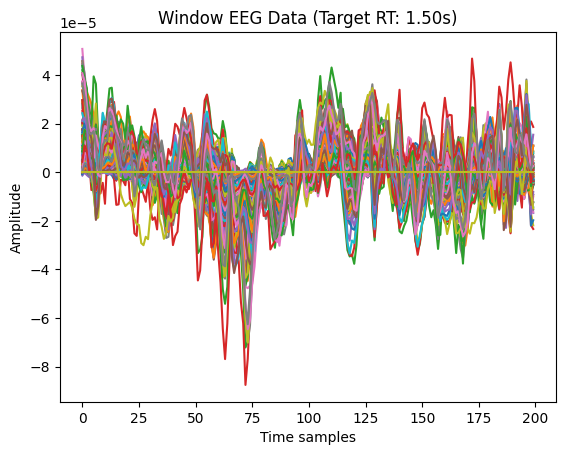

In [14]:
import matplotlib.pyplot as plt
plt.plot(EEG_1.T)  # plot all channels over time
plt.title(f"Window EEG Data (Target RT: {target_1.item():.2f}s)")
plt.xlabel("Time samples")
plt.ylabel("Amplitude")
plt.show()

https://www.geeksforgeeks.org/deep-learning/pytorch-dataloader/

**Batching**: process of grouping data samples into smaller chunks (batches) for efficient training. Enables parallel processing

**Shuffle**: random reordering of data samples for every epoch

**num_workers**: can speed up data loading by allowing multiple samples to be loaded concurrently

In [15]:
# Create dataloaders
from torch.utils.data import DataLoader

batch_size = 128
num_workers = 1 # We are using a single worker, but you can increase this for faster data loading

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

**ResNet-18 Source:**
https://www.geeksforgeeks.org/deep-learning/resnet18-from-scratch-using-pytorch/
- 18 layers (convulotional layers and residual blocks)

**Batch Normalization:** normalizing the inputs of each layer.
- training is faster and more stable
- avoid the vanishing gradient problem
- solves [internal covariate shift](https://www.geeksforgeeks.org/deep-learning/internal-covariant-shift-problem-in-deep-learning/) (different distributions of data within batches)

In [17]:
import numpy as np
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [18]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
      identity = x

      # Apply the first convolution, batch norm, and ReLU activation
      out = self.conv1(x)
      out = self.bn1(out)
      out = self.relu(out)

      # Apply the second convolution and batch norm
      out = self.conv2(out)
      out = self.bn2(out)

      # Handle downsampling if required
      if self.downsample is not None:
          identity = self.downsample(x)

      # Add skip connection
      out += identity
      out = self.relu(out)

      return out

In [32]:

class ResNet18(nn.Module):
  def __init__(self, num_classes=1):  # regression
    super(ResNet18, self).__init__()
    self.in_channels = 64
    self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
    self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
    self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
    self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512, num_classes)

  def _make_layer(self, block, out_channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

  def forward(self, x):
    out = self.conv1(x) #Convolutional layer: extract features
    out = self.bn1(out) #batch normalization
    out = self.relu(out)
    out = self.maxpool(out)

    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)

    out = self.avgpool(out)
    out = torch.flatten(out, 1)
    out = self.fc(out)
    return out

In [49]:
import torch.optim as optim

model = ResNet18(num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

In [42]:
for batch in train_loader:
    inputs, labels, _ = batch
    print("Original shape:", inputs.shape)
    break

Original shape: torch.Size([128, 129, 200])


In [43]:
num_epochs = 30
loss_list = []
rmse_list = []


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        inputs, labels, _ = batch
        inputs = inputs.unsqueeze(1)  # shape becomes [batch, 1, 129, 200]

        # move to device
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)

        # reshape after  load inputs
        if inputs.ndim == 3:
            # add spatial dimension
            inputs = inputs.unsqueeze(2)  # -> [batch, 128, 1, 200]

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs.squeeze(), labels)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()

        rmse = torch.sqrt(loss)
        rmse_list.append(rmse.item())
        train_loss += loss.item()

    avg_rmse = sum(rmse_list) / len(rmse_list)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, RMSE: {avg_rmse:.4f}")


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([63, 1])) that is different to the input size (torch.Size([63])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Loss: 12.9377, RMSE: 1.0222
Epoch [2/30], Loss: 2.9435, RMSE: 0.7770
Epoch [3/30], Loss: 2.1011, RMSE: 0.6703
Epoch [4/30], Loss: 2.1194, RMSE: 0.6174
Epoch [5/30], Loss: 2.0522, RMSE: 0.5839
Epoch [6/30], Loss: 2.0432, RMSE: 0.5616
Epoch [7/30], Loss: 2.6065, RMSE: 0.5527
Epoch [8/30], Loss: 2.0978, RMSE: 0.5405
Epoch [9/30], Loss: 2.1462, RMSE: 0.5317
Epoch [10/30], Loss: 2.3927, RMSE: 0.5270
Epoch [11/30], Loss: 2.1349, RMSE: 0.5210
Epoch [12/30], Loss: 1.9011, RMSE: 0.5138
Epoch [13/30], Loss: 1.9508, RMSE: 0.5081
Epoch [14/30], Loss: 2.1206, RMSE: 0.5045
Epoch [15/30], Loss: 1.9871, RMSE: 0.5003
Epoch [16/30], Loss: 2.1278, RMSE: 0.4977
Epoch [17/30], Loss: 2.0344, RMSE: 0.4949
Epoch [18/30], Loss: 1.9899, RMSE: 0.4920
Epoch [19/30], Loss: 1.9899, RMSE: 0.4894
Epoch [20/30], Loss: 2.1043, RMSE: 0.4878
Epoch [21/30], Loss: 1.9250, RMSE: 0.4854
Epoch [22/30], Loss: 2.0009, RMSE: 0.4836
Epoch [23/30], Loss: 2.1157, RMSE: 0.4825
Epoch [24/30], Loss: 2.0025, RMSE: 0.4809


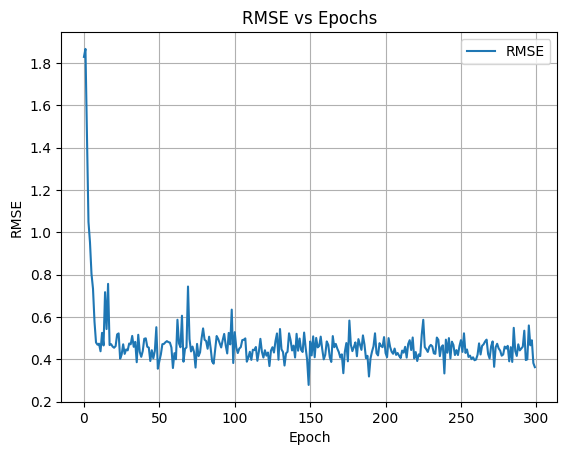

In [47]:
plt.plot(rmse_list, label= "RMSE")

plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

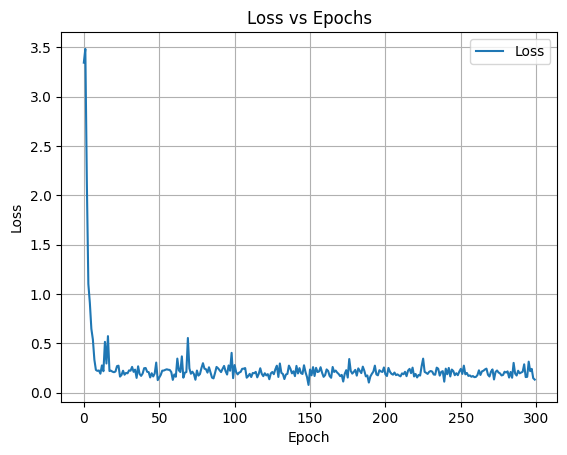

In [46]:
plt.plot(loss_list, label= "Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()